In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# All imports are defined here:-

In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Defining Training Directories and CSV's:-

In [3]:
train_dir="/kaggle/input/signature-verification-dataset/sign_data/train"
train_csv="/kaggle/input/signature-verification-dataset/sign_data/train_data.csv"
test_csv="/kaggle/input/signature-verification-dataset/sign_data/test_data.csv"
test_dir="/kaggle/input/signature-verification-dataset/sign_data/test"

In [4]:
df_train=pd.read_csv(train_csv)
df_train.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
10593,048/11_048.png,048/01_048.png,0
16824,020/04_020.png,020/02_020.png,0
20091,063/07_063.png,063_forg/04_0119063.PNG,1
17623,013/01_013.png,013_forg/02_0203013.PNG,1
243,033/05_033.png,033_forg/03_0203033.PNG,1
3568,026/10_026.png,026/11_026.png,0
17057,017/07_017.png,017_forg/03_0107017.PNG,1
13894,018/06_018.png,018/04_018.png,0
11255,003/003_04.PNG,003/003_05.PNG,0
17317,054/01_054.png,054_forg/02_0207054.PNG,1


# Here we are seeing that 1 denotes for forged pair and 0 denotes for geniune pair of signatures..

In [5]:
df_test=pd.read_csv(test_csv)
df_test.sample(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
5695,066/08_066.png,066/07_066.png,0
2896,069/03_069.png,069/02_069.png,0
4330,063/03_063.png,063_forg/03_0104063.PNG,1
1811,055/03_055.png,055_forg/03_0202055.PNG,1
5048,064/04_064.png,064/05_064.png,0
3502,052/11_052.png,052_forg/01_0109052.PNG,1
1753,050/06_050.png,050/10_050.png,0
1340,051/08_051.png,051_forg/01_0120051.PNG,1
4914,059/02_059.png,059/07_059.png,0
4296,063/02_063.png,063_forg/04_0108063.PNG,1


In [6]:
df_train.shape

(23205, 3)

In [7]:
df_test.shape

(5747, 3)

# Making Custom Pytorch Siamese Dataset:-

the ____len____ function which returns the size of the dataset, and

the ____getitem____ function which returns a sample from the dataset given an index.

In [8]:
df_train[4:5]

,068/09_068.png,068_forg/03_0113068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [9]:
image1_path=os.path.join(train_dir,df_train.iat[4,0])
image1_path

'/kaggle/input/signature-verification-dataset/sign_data/train/068/09_068.png'

In [10]:
class Dataset(Dataset):
    #default constuctor for assigning values
    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
    def __getitem__(self,idx): ## __getitem__ returns a sample data given index, idx=index
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
        
        img1=img1.convert('L') #L mode image, that means it is a single channel image - normally interpreted as greyscale.
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    
    def __len__(self): ## __len__ returns the size of the dataset..
        return len(self.train_data)

# Returns Image1, Image2 and the class label(whether 0 or 1).

In [11]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [12]:
dataset

# Siamese Network:-

In [13]:
class SiameseNetwork(nn.Module):
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        
        self.conv1=nn.Conv2d(1,50,kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
         # L1 ImgIn shape=(?, 28, 28, 1)      # (n-f+2*p/s)+1
        #    Conv     -> (?, 24, 24, 50)
        #    Pool     -> (?, 12, 12, 50)
        
        
        self.conv2 = nn.Conv2d(50,60, kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        # L2 ImgIn shape=(?, 12, 12, 50)
        #    Conv      ->(?, 8, 8, 60)
        #    Pool      ->(?, 4, 4, 60)
        
        
        self.conv3 = nn.Conv2d(60, 80,  kernel_size = 3)
        # L3 ImgIn shape=(?, 4, 4, 60)
        #    Conv      ->(?, 2, 2, 80)
       
        
        
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.batch_norm2 = nn.BatchNorm2d(60)
        
#         self.dropout1 = nn.Dropout2d()
        
        # L4 FC 2*2*80 inputs -> 250 outputs
        self.fc1 = nn.Linear(32000, 128) 
        self.fc2 = nn.Linear(128, 2)
        
      
    
    
    def forward1(self,x):
        x=self.conv1(x)
        x = self.batch_norm1(x)
        x=F.relu(x)
        x=self.pool1(x)
        
        x=self.conv2(x)
        x = self.batch_norm2(x)
        x=F.relu(x)
        x=self.pool2(x)
        
        x=self.conv3(x)
        x=F.relu(x)
#         print(x.size())
        x = x.view(x.size()[0], -1)
#         print('Output2')
#         print(x.size()) #32000 thats why the input of fully connected layer is 32000
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward1(input1)
        # forward pass of input 2
        output2 = self.forward1(input2)
        
        return output1, output2


# Constrastive Loss Function:-

Contrastive loss:-
Contrastive loss is widely-used in unsupervised and self-supervised learning. Originally developed by Hadsell et al. in 2016 from Yann LeCun’s group, this loss function operates on pairs of samples instead of individual samples. It defines a binary indicator Y for each pair of samples stating whether they should be deemed similar, and a learnable distance function D_W(x_1, x_2) between a pair of samples x_1, x_2, parameterized by the weights W in the neural network. 

, where m>0 is a margin. The margin defines a radius around the embedding space of a sample so that dissimilar pairs of samples only contribute to the contrastive loss function if the distance D_W is within the margin.


Intuitively, this loss function encourages the neural network to learn a embedding to place samples with the same labels close to each other, while distancing the samples with different labels in the embedding space.

In [14]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
    

In [15]:
train_dataloader = DataLoader(dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

In [16]:
train_dataloader

In [17]:
if torch.cuda.is_available():
    print('Yes')

Yes


In [18]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()               
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [19]:
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [20]:
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch 1
 Current loss 0.6451321244239807

Epoch 2
 Current loss 0.5862798690795898

Epoch 3
 Current loss 0.5035299062728882

Epoch 4
 Current loss 0.7723994851112366

Epoch 5
 Current loss 0.8708722591400146

Epoch 6
 Current loss 0.5968277454376221

Epoch 7
 Current loss 0.6465072631835938

Epoch 8
 Current loss 0.7000749111175537

Epoch 9
 Current loss 0.4968913197517395

Model Saved Successfully


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>

In [22]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=8,batch_size=1,shuffle=True)

In [23]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Testing the model by comparing the model's distance prediction between two pairs of Signature:-

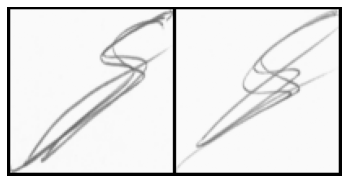

Predicted Eucledian Distance:- 0.4027693569660187
Actual Label:- Original Pair Of Signature


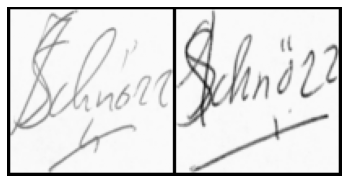

Predicted Eucledian Distance:- 0.6175956726074219
Actual Label:- Forged Pair Of Signature


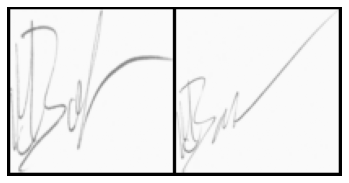

Predicted Eucledian Distance:- 0.14530692994594574
Actual Label:- Original Pair Of Signature


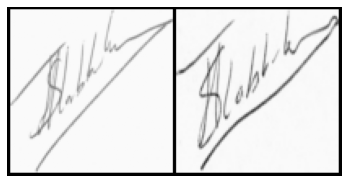

Predicted Eucledian Distance:- 0.3902818262577057
Actual Label:- Forged Pair Of Signature


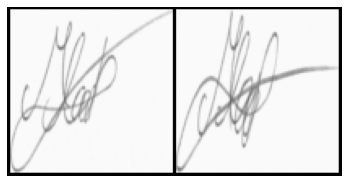

Predicted Eucledian Distance:- 0.420575350522995
Actual Label:- Original Pair Of Signature


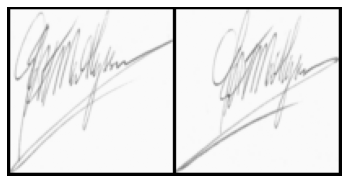

Predicted Eucledian Distance:- 0.8933793306350708
Actual Label:- Original Pair Of Signature


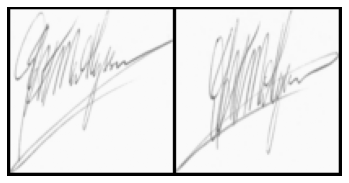

Predicted Eucledian Distance:- 0.11032260954380035
Actual Label:- Original Pair Of Signature


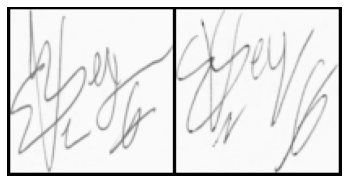

Predicted Eucledian Distance:- 0.3986208140850067
Actual Label:- Forged Pair Of Signature


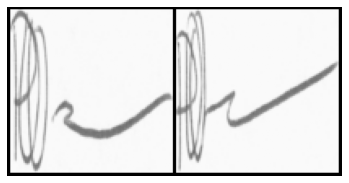

Predicted Eucledian Distance:- 0.6948906183242798
Actual Label:- Original Pair Of Signature


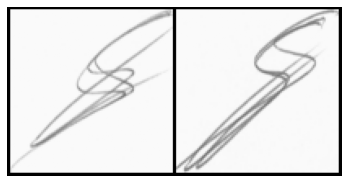

Predicted Eucledian Distance:- 0.026691904291510582
Actual Label:- Original Pair Of Signature


In [26]:
count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))

  eucledian_distance = F.pairwise_distance(output1, output2)
    
  if label==torch.FloatTensor([[0]]):
    label="Original Pair Of Signature"
  else:
    label="Forged Pair Of Signature"
    
  imshow(torchvision.utils.make_grid(concat))
  print("Predicted Eucledian Distance:-",eucledian_distance.item())
  print("Actual Label:-",label)
  count=count+1
  if count ==10:
     break

# Mostly our model is predicting the distances quite well.